<a href="https://colab.research.google.com/github/Huda-AlGhussein/BERT-for-studying-/blob/main/Trial_8%2B_embalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Mon Nov 14 12:39:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    14W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [ ]:
!pip install transformers==4.12.2
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 37.1 MB/s 
     |████████████████████████████████| 163 kB 63.3 MB/s 
     |████████████████████████████████| 880 kB 63.2 MB/s 
     |████████████████████████████████| 3.3 MB 54.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=a035d719b4a349f4b3d38d40f95b737d76377e0bef6c45e66e7fec646899b868
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 35.3 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remo

In [ ]:
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [ ]:
import pandas as pd
import numpy as np
from typing import List
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
import pandas as pd
import re

drive.mount('/content/gdrive')
data= pd.read_excel(r'/content/gdrive/MyDrive/Tweets.xlsx')

#drive.mount('/content/drive')

#data = pd.read_csv('/content/drive/MyDrive/Capstone Project/TweetsDataset.csv')

Mounted at /content/gdrive


In [ ]:
df= pd.DataFrame(data)
df = df.set_index('Index')
print(df)

                     Date             User  \
Index                                        
0     2022-10-28 02:18:00  hFeDhLX313kUF8q   
1     2022-10-27 22:53:00      SalamReslan   
2     2022-10-27 22:44:00    Bandaralshafi   
3     2022-10-27 22:38:00    hanadi_abdali   
4     2022-10-27 15:45:00   Zafer_Albishri   
...                   ...              ...   
995   2022-10-19 15:32:00           i22MTi   
996   2022-10-19 15:32:00           i22MTi   
997   2022-10-19 15:30:00           i22MTi   
998   2022-10-19 15:29:00           i22MTi   
999   2022-10-19 15:29:00           i22MTi   

                                                   Tweet Label  
Index                                                           
0      @khalidjassem74 مقدم على بطاقة هيا من 16 يوم م...  safe  
1      @hamadlahdan ما أجمل أن تمحو قطر من أذهان ورؤى...  safe  
2      #حياكم_قطر \n #Welcome_to_qatar \n #QatarWorld...  safe  
3      Souvenir حلو للمونديال 🥰 \n #مونديال_قطر_2022 ...  safe  
4      #فخر

In [ ]:
# define dictionary 
labels = {'safe':0, 'toxic':1}

#df['Label'] = df['Label'].apply(lambda x: labels[x])
# print head to verify
df.head()

,Date,User,Tweet,Label
Index,,,,
0,2022-10-28 02:18:00,hFeDhLX313kUF8q,@khalidjassem74 مقدم على بطاقة هيا من 16 يوم م...,safe
1,2022-10-27 22:53:00,SalamReslan,@hamadlahdan ما أجمل أن تمحو قطر من أذهان ورؤى...,safe
2,2022-10-27 22:44:00,Bandaralshafi,#حياكم_قطر \n #Welcome_to_qatar \n #QatarWorld...,safe
3,2022-10-27 22:38:00,hanadi_abdali,Souvenir حلو للمونديال 🥰 \n #مونديال_قطر_2022 ...,safe
4,2022-10-27 15:45:00,Zafer_Albishri,#فخرنا_الأخضر .. \n \n الأغنية الرسمية ل #المن...,safe


(array([488.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 488.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

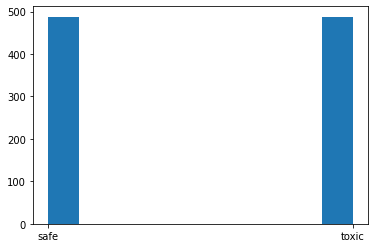

In [ ]:
features= ['Date', 'User','Tweet']
x = df[features]
y = df['Label'] 

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

over = RandomOverSampler(sampling_strategy= 0.5)
x_new, y_new = over.fit_resample(x, y)

under = RandomUnderSampler(sampling_strategy= 1)
new_data, new_label = under.fit_resample(x_new, y_new)

plt.hist(new_label)

In [ ]:
print(new_data.head(5))

                 Date     User  \
0 2022-10-07 20:36:00  wejhatt   
1 2022-10-25 12:49:00   224pmn   
2 2022-10-25 03:38:00   i22MTi   
3 2022-10-25 03:37:00   i22MTi   
4 2022-10-23 13:12:00   i22MTi   

                                               Tweet  
0  هنا #قطر \n 🎥 جريدة #وجهات \n أحدى القاعات في ...  
1  وأحنا لها ومستعدين لهذا العرس الكروي العالمي ب...  
2  كمية قليلة\n تنبيه هام\n المباراة40: 🇸🇦 السعود...  
3  احد يفهمني ليه هالمباراة قوية🥹\n المباراة15: 🇵...  
4  المباراة 32: 🇵🇹 البرتغال vs اوروغواي 🇺🇾 متاحة ...  


In [ ]:
#tweets.columns = [Text_Column, Label_Column]

#tweet_train, tweet_temp, label_train, label_temp = train_test_split(new_data['Tweet'], new_label,test_size=0.3, random_state=42)
#tweet_val, tweet_test, label_val, label_test = train_test_split(tweet_temp, label_temp,test_size=0.5, random_state=42)
tweet_train, tweet_test, label_train, label_test = train_test_split(new_data['Tweet'], new_label,test_size=0.3, random_state=42)
label_list = list(new_label.unique())
print(new_label.value_counts())

safe     488
toxic    488
Name: Label, dtype: int64


In [ ]:
model_name = 'aubmindlab/bert-base-arabertv02-twitter' # we are going to use the twitter AraBERT since it has emojis and dialects

In [ ]:
arabic_prep = ArabertPreprocessor(model_name)

tweet_train = tweet_train.apply(lambda x: arabic_prep.preprocess(x))
#tweet_val= tweet_val.apply(lambda x: arabic_prep.preprocess(x))
tweet_test = tweet_test.apply(lambda x: arabic_prep.preprocess(x))  

In [ ]:
tok = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/476 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/733k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Training Sentence Lengths: 


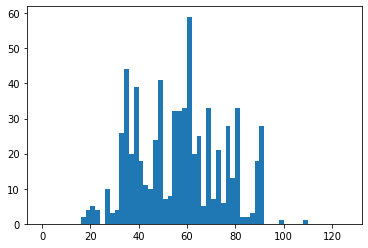

Testing Sentence Lengths: 


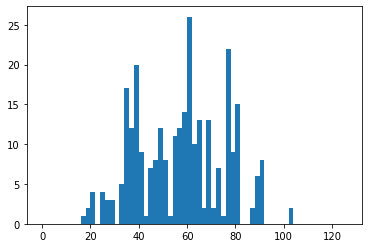

In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in tweet_train.to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in tweet_test.to_list()],bins=range(0,128,2))
plt.show()

In [ ]:
max_len = 128

In [ ]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in tweet_train.to_list()]),
      "out of {}".format(tweet_train.shape))
#print("Truncated validation sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in tweet_val.to_list()]),
     # "out of {}".format(tweet_val.shape))
print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in tweet_test.to_list()]),
      "out of {}".format(tweet_test.shape))

Truncated training sequences:  1 out of (683,)
Truncated testing sequences:  1 out of (293,)


In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
      

    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
        
      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )      
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [ ]:
label_map = { v:index for index, v in enumerate(label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    tweet_train.to_list(),
    label_train.to_list(),
    model_name,
    max_len,
    label_map
  )
#eval_dataset= ClassificationDataset(
 #   tweet_val.to_list(),
  #  label_val.to_list(),
   # model_name,
    #max_len,
    #label_map)
test_dataset = ClassificationDataset(
    tweet_test.to_list(),
    label_test.to_list(),
    model_name,
    max_len,
    label_map
  )

{'safe': 0, 'toxic': 1}


In [ ]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[2, 10, 54, 6350, 5954, 274, 51459, 251, 34609, 5663, 11918, 54, 39096, 41672, 30001, 60, 51459, 40, 34609, 6794, 7830, 3240, 770, 465, 306, 5831, 64, 3879, 66, 91, 19674, 64, 8465, 66, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print(next(iter(test_dataset)))

InputFeatures(input_ids=[2, 64, 8465, 66, 64, 8465, 66, 64, 8465, 66, 740, 4802, 718, 193, 4781, 485, 838, 13273, 740, 4802, 718, 193, 1882, 3633, 45506, 5248, 186, 39818, 740, 4802, 718, 193, 740, 4802, 718, 193, 740, 4802, 718, 193, 36693, 3760, 181, 43051, 28024, 193, 740, 4802, 718, 193, 10, 28381, 18201, 61982, 10, 3240, 10, 6479, 10, 54, 6350, 5954, 5663, 11918, 10, 54, 6350, 5954, 274, 51459, 251, 34609, 5663, 11918, 10, 3240, 68, 2191, 10, 2109, 68, 619, 68, 3240, 68, 30001, 10, 2109, 68, 619, 10, 305, 68, 3423, 68, 3240, 10, 11323, 593, 68, 3240, 64, 3879, 66, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
def get_model():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [ ]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  #print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))
  f1 = f1_score(p.label_ids,preds,average='macro')
  #precision = precision_score(p.label_ids,preds,average='macro')
  #recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {       
      'f1' : f1,
      'accuracy': acc
  }

In [ ]:
def set_seed(seed=42): #helper function
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

In [ ]:
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 8,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 4,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'f1',
    greater_is_better = True,
  )

#set_seed(training_args.seed)

In [ ]:
trainer = Trainer(
    model= get_model(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Downloading:   0%|          | 0.00/667 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

In [ ]:
#start the training
trainer.train()

***** Running training *****
  Num examples = 683
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 84


Epoch,Training Loss,Validation Loss,F1,Accuracy
0,No log,0.067967,0.989753,0.989761
1,No log,0.026052,0.989753,0.989761
2,No log,0.017011,0.993170,0.993174
3,No log,0.021825,0.993170,0.993174


***** Running Evaluation *****
  Num examples = 293
  Batch size = 8
Saving model checkpoint to ./train/checkpoint-21
Configuration saved in ./train/checkpoint-21/config.json
Model weights saved in ./train/checkpoint-21/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 293
  Batch size = 8
Saving model checkpoint to ./train/checkpoint-42
Configuration saved in ./train/checkpoint-42/config.json
Model weights saved in ./train/checkpoint-42/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 293
  Batch size = 8
Saving model checkpoint to ./train/checkpoint-63
Configuration saved in ./train/checkpoint-63/config.json
Model weights saved in ./train/checkpoint-63/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 293
  Batch size = 8
Saving model checkpoint to ./train/checkpoint-84
Configuration saved in ./train/checkpoint-84/config.json
Model weights saved in ./train/checkpoint-84/pytorch_model.bin


Training completed. Do not forget to share you

TrainOutput(global_step=84, training_loss=0.08714934190114339, metrics={'train_runtime': 101.0463, 'train_samples_per_second': 27.037, 'train_steps_per_second': 0.831, 'total_flos': 178981295408640.0, 'train_loss': 0.08714934190114339, 'epoch': 3.98})

In [ ]:
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

Saving model checkpoint to output_dir
Configuration saved in output_dir/config.json


{0: 'safe', 1: 'toxic'}


Model weights saved in output_dir/pytorch_model.bin
tokenizer config file saved in output_dir/tokenizer_config.json
Special tokens file saved in output_dir/special_tokens_map.json


('output_dir/tokenizer_config.json',
 'output_dir/special_tokens_map.json',
 'output_dir/vocab.txt',
 'output_dir/added_tokens.json',
 'output_dir/tokenizer.json')

In [ ]:
#copy the model to drive
!cp output_dir /content/drive/MyDrive

cp: -r not specified; omitting directory 'output_dir'


In [ ]:
from transformers import pipeline
from transformers import TextClassificationPipeline

In [ ]:
# initialize pipline
#pipe = TextClassificationPipeline(model= get_model(), tokenizer=tok, return_all_scores=True)
pipe = pipeline("sentiment-analysis", model="output_dir", device=0, return_all_scores=False)

loading configuration file output_dir/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "safe",
    "1": "toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "safe": 0,
    "toxic": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading configuration file output_dir/config.json
Model config BertCon

In [ ]:
pipe("يمكن متابعه المباراه على القناه التاليه")

[{'label': 'safe', 'score': 0.9902061820030212}]

In [ ]:
pipe(" انت غبي ")

[{'label': 'toxic', 'score': 0.6232064366340637}]

In [ ]:
pipe("منافق")

[{'label': 'toxic', 'score': 0.8868938088417053}]

# **Streamlit**

In [ ]:
!pip install streamlit --quiet

!pip install pyngrok --quiet
!pip install fastapi --quiet 
!pip install fastapi nest-asyncio pyngrok uvicorn --quiet
!pip install streamlit --quiet

     |████████████████████████████████| 9.2 MB 32.0 MB/s 
     |████████████████████████████████| 4.7 MB 56.9 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 164 kB 67.0 MB/s 
     |████████████████████████████████| 182 kB 72.3 MB/s 
     |████████████████████████████████| 237 kB 64.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 
     |████████████████████████████████| 745 kB 38.6 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 64 kB 2.8 MB/s 
     |████████████████████████████████| 80 kB 9.9 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 


In [ ]:
from pyngrok import ngrok
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import streamlit as st
import spacy

In [ ]:
from transformers import pipeline

In [ ]:
%%writefile app.py
import streamlit as st
st.write('# Tweet Analyzer in Arabic')
st.write('## Analyze your Arabic tweets and let AI tell you how much it is toxic and safe ')
with st.form(key='my_form'):
    user_input = st.text_input(label='Enter some text')
    submit_button = st.form_submit_button(label='Submit')

st.write('The score is: ')
with st.echo():
 from transformers import pipeline
 pipe = pipeline("sentiment-analysis", model="output_dir", device=0, return_all_scores=False)
 result= pipe(user_input)
 st.write(result)

Writing app.py


In [ ]:
from pyngrok import ngrok

In [ ]:
ngrok.kill()
ngrok.set_auth_token("2HWtqs3Vt8MimSIi2ObMuGJd41w_UP5Xn34zGjhsWeM4rGSM") #ngrok.com

INFO:pyngrok.process:Updating authtoken for default "config_path" of "ngrok_path": /usr/local/lib/python3.7/dist-packages/pyngrok/bin/ngrok
2022-11-14 12:43:49.927 INFO    pyngrok.process: Updating authtoken for default "config_path" of "ngrok_path": /usr/local/lib/python3.7/dist-packages/pyngrok/bin/ngrok


In [ ]:
ngrok.kill()

In [ ]:
!nohup streamlit run app.py --server.port 80 &
url = ngrok.connect(port = '80')
print(url)

nohup: appending output to 'nohup.out'


INFO:pyngrok.ngrok:Opening tunnel named: http-80-13250c23-2f14-4896-9bae-4df6ceb4ca12
2022-11-14 12:43:50.350 INFO    pyngrok.ngrok: Opening tunnel named: http-80-13250c23-2f14-4896-9bae-4df6ceb4ca12
INFO:pyngrok.process.ngrok:t=2022-11-14T12:43:50+0000 lvl=info msg="no configuration paths supplied"
2022-11-14 12:43:50.616 INFO    pyngrok.process.ngrok: t=2022-11-14T12:43:50+0000 lvl=info msg="no configuration paths supplied"
INFO:pyngrok.process.ngrok:t=2022-11-14T12:43:50+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
2022-11-14 12:43:50.624 INFO    pyngrok.process.ngrok: t=2022-11-14T12:43:50+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
INFO:pyngrok.process.ngrok:t=2022-11-14T12:43:50+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil
2022-11-14 12:43:50.633 INFO    pyngrok.process.ngrok: t=2022-11-14T12:43:50+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngro

NgrokTunnel: "http://69e8-35-240-229-8.ngrok.io" -> "http://localhost:80"


INFO:pyngrok.process.ngrok:t=2022-11-14T12:43:51+0000 lvl=info msg="started tunnel" obj=tunnels name=http-80-13250c23-2f14-4896-9bae-4df6ceb4ca12 addr=http://localhost:80 url=https://69e8-35-240-229-8.ngrok.io
2022-11-14 12:43:51.931 INFO    pyngrok.process.ngrok: t=2022-11-14T12:43:51+0000 lvl=info msg="started tunnel" obj=tunnels name=http-80-13250c23-2f14-4896-9bae-4df6ceb4ca12 addr=http://localhost:80 url=https://69e8-35-240-229-8.ngrok.io
INFO:pyngrok.process.ngrok:t=2022-11-14T12:43:51+0000 lvl=info msg=end pg=/api/tunnels id=f769348cee2421d1 status=201 dur=488.631138ms
2022-11-14 12:43:51.946 INFO    pyngrok.process.ngrok: t=2022-11-14T12:43:51+0000 lvl=info msg=end pg=/api/tunnels id=f769348cee2421d1 status=201 dur=488.631138ms
INFO:pyngrok.process.ngrok:t=2022-11-14T12:43:51+0000 lvl=info msg=start pg="/api/tunnels/http-80-13250c23-2f14-4896-9bae-4df6ceb4ca12 (http)" id=3e8089b34ebd7b73
2022-11-14 12:43:51.957 INFO    pyngrok.process.ngrok: t=2022-11-14T12:43:51+0000 lvl=info 